# Image Segmentation Task 3

In [2]:
!pip install positional_encodings;
!pip install cityscapesscripts;

     |████████████████████████████████| 472 kB 10.1 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 11.3 MB/s eta 0:00:01
     |████████████████████████████████| 45 kB 13.6 MB/s eta 0:00:01
     |████████████████████████████████| 86 kB 18.8 MB/s eta 0:00:01


### Imports

In [12]:
import os
import math
import random
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from datasets.cityscapes import cityscapesDataset
from datasets.pascalvoc import pascalVOCDataset

### Setup

In [13]:
# reproducibility setups
torch.manual_seed(253452757)
random.seed(253452757)
np.random.seed(253452757)

In [14]:
local_path = "./Cityscapes"
os.environ["CUDA_VISIBLE_DEVICES"]="3" 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Hyperparameters

In [15]:
bs = 5
epochs = 15
learning_rate = 0.0002

### Dataset and Dataloader

In [16]:
training_data = cityscapesDataset(local_path, split="train")
validation_data = cityscapesDataset(local_path, split="val")
test_data = cityscapesDataset(local_path, split="test")

AssertionError: unexpedted data size

In [6]:
dataset_sizes = {
    'train': len(training_data),
    'val': len(validation_data),
    'test': len(test_data),
    'total': len(training_data) + len(validation_data) + len(test_data)
}

dataset_sizes

{'train': 2975, 'val': 500, 'test': 1525, 'total': 5000}

In [7]:
dataloaders = {
    'train': DataLoader(training_data, batch_size=bs, shuffle=True),
    'val': DataLoader(validation_data, batch_size=bs, shuffle=True),
    'test': DataLoader(test_data, batch_size=bs, shuffle=True),
}

In [8]:
img, lbl = training_data[0]

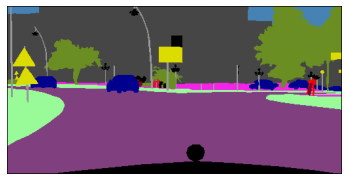

In [9]:
training_data.decode_segmap(lbl.numpy(), plot=True)

### Model setup

In [14]:
import importlib
import networks.r2unet_hanet 
import networks.hanet
importlib.reload(networks.hanet)
importlib.reload(networks.r2unet_hanet)

<module 'networks.r2unet_hanet' from '/project/simple-imageseg/networks/r2unet_hanet.py'>

In [15]:
model = networks.r2unet_hanet.R2Unet16HANet(hanet_layers=2).to(device)

In [16]:
model

R2Unet16HANet(
  (downsample1): Downsample(
    (rrcu): RRConv(
      (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (rconv1): RConv(
        (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (rconv2): RConv(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (downsample2): Downsample(
    (rrcu): RRConv(
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (rconv1): RConv(
        (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(32, 32, ke

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_f = nn.CrossEntropyLoss(ignore_index = 255)

### Training

In [12]:
import os 
import copy
import torch
import numpy as np
from os.path import join as pjoin

In [15]:
import training
importlib.reload(training)

<module 'training' from '/project/simple-imageseg/training.py'>

In [27]:
labels = training_data.label_ids()[1:-1]
labels 

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

In [28]:
model_path = 'models/r2unet_hanet16/2/w_o'
if not os.path.isdir(model_path):
    os.makedirs(model_path)

In [18]:
model = training.train_early_stopping(model, dataloaders, dataset_sizes, model_path, loss_f, optimizer)

Training started
----------
Epoch: 0 - [Train] Loss: 1.6029
Epoch: 1 - [Train] Loss: 0.9298
Epoch: 1 - [Val] Loss: 955.1135, fails: 0
Epoch: 2 - [Train] Loss: 0.8222
Epoch: 3 - [Train] Loss: 0.7449
Epoch: 3 - [Val] Loss: 812.7774, fails: 0
Epoch: 4 - [Train] Loss: 0.6868
Epoch: 5 - [Train] Loss: 0.6389
Epoch: 5 - [Val] Loss: 682.1341, fails: 0
Epoch: 6 - [Train] Loss: 0.6047
Epoch: 7 - [Train] Loss: 0.5791
Epoch: 7 - [Val] Loss: 706.3628, fails: 1
Epoch: 8 - [Train] Loss: 0.5597
Epoch: 9 - [Train] Loss: 0.5421
Epoch: 9 - [Val] Loss: 672.2422, fails: 0
Epoch: 10 - [Train] Loss: 0.5245
Epoch: 11 - [Train] Loss: 0.5103
Epoch: 11 - [Val] Loss: 695.1341, fails: 1
Epoch: 12 - [Train] Loss: 0.4987
Epoch: 13 - [Train] Loss: 0.4842
Epoch: 13 - [Val] Loss: 679.8193, fails: 2


### Evaluate the results

In [26]:
from evaluation import EvaluationReport

In [13]:
checkpoint = torch.load(pjoin(model_path, "best_model.pt"))

In [17]:
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [30]:
eval_report = EvaluationReport.from_model(dataloaders['val'], model, labels)

In [31]:
eval_report.f1_score(average="macro")

0.1841

### Visualize the results

In [24]:
from utils import plot_seg_results

In [21]:
dataloader = torch.utils.data.DataLoader(training_data, batch_size=10, shuffle=True, num_workers=0)
images, ground_truths = next(iter(dataloader))
outputs = model(images.to(device))
predictions = torch.argmax(outputs.squeeze().cpu(), dim = 1)

In [22]:
images = [img.permute(1, 2, 0).numpy() for img in images]
predictions = [training_data.decode_segmap(pred.numpy()) for pred in predictions]
ground_truths = [training_data.decode_segmap(gt.numpy()) for gt in ground_truths]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

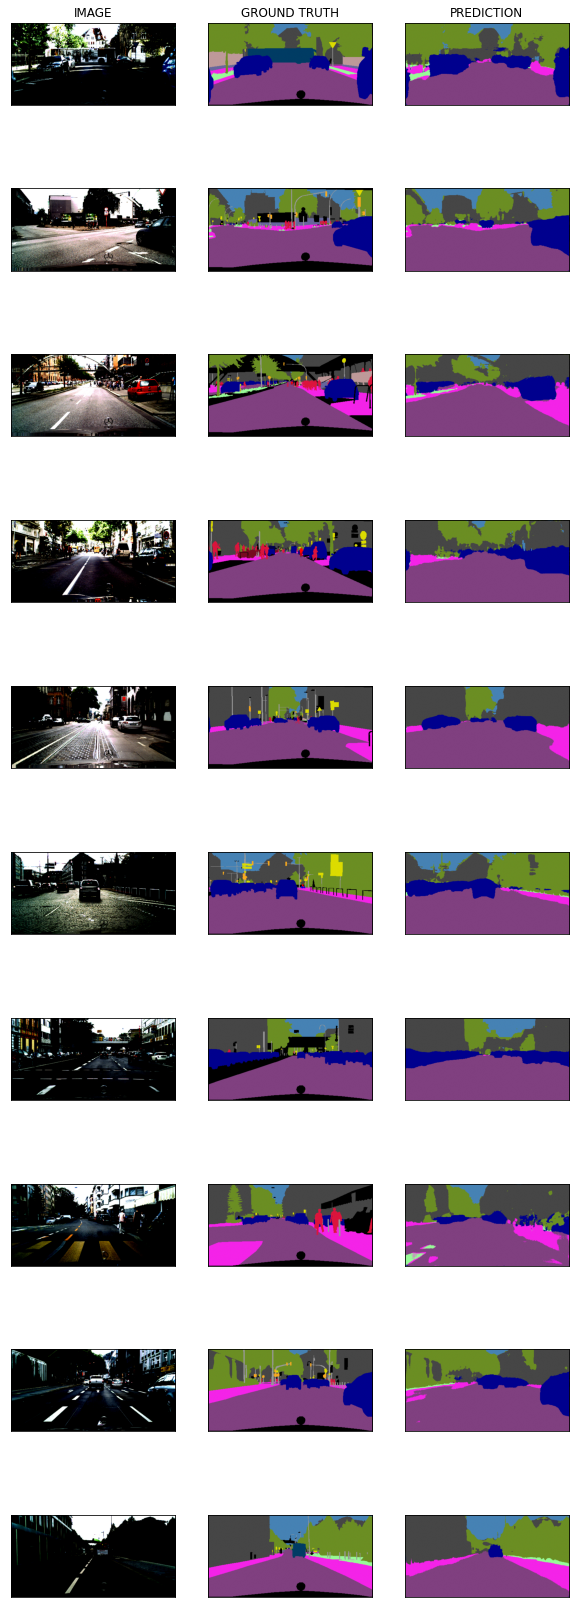

In [25]:
plot_seg_results(images, ground_truths, predictions)